# 1 Library

In [1]:
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
import xgboost as xgb

# Filter out warnings
os.environ['PYTHONWARNINGS']='ignore'
warnings.filterwarnings(action='ignore')

# 2 Loading the Data & Preprocessing

#### Preprocessing Functions

- `trim_tail` function: trim the tail of the data to reduce the influence of extreme values.
- `do_knn_impute` function: perform KNN imputation of missing values.
- `load_preprocess` function: apply the entire preprocessing trasformation.

In [2]:
def trim_tail(data, lower_percentile, upper_percentile):
    """
    Trim the tail of the data to reduce the influence of extreme values.

    Args:
    - data (array_like): The data to be trimmed.
    - lower_percentile (float): Lower percentile for trimming.
    - upper_percentile (float): Upper percentile for trimming.

    Returns:
    - array_like: Trimmed data.
    """
    low, high = np.percentile(data, [lower_percentile, upper_percentile])
    return np.clip(data, low, high)

def do_knn_impute(train_data, test_data, neighbors):
    """
    Perform KNN imputation on train and test data.

    Args:
    - train_data (DataFrame): Training data to be imputed.
    - test_data (DataFrame): Test data to be imputed.
    - neighbors (int): Number of neighbors for KNN imputation.

    Returns:
    - tuple: Tuple containing imputed train and test data.
    """
    knn_imputer = KNNImputer(n_neighbors=neighbors)
    train_data_filled = knn_imputer.fit_transform(train_data)
    test_data_filled = knn_imputer.transform(test_data)

    columns_lst = list(train_data.columns)
    train_data = pd.DataFrame(train_data_filled, columns=columns_lst, index=train_data.index)
    test_data = pd.DataFrame(test_data_filled, columns=columns_lst, index=test_data.index)
    return train_data, test_data

def load_preprocess(separate_country=False):
    """
    Load and preprocess the data.

    Args:
    - separate_country (bool): Whether to separate data by country.

    Returns:
    - list or tuple: Preprocessed data depending on the value of `separate_country`.
    """
    # Load train and set
    X_train = pd.read_csv('X_train.csv', index_col='ID').drop(columns=["DAY_ID"])
    Y_train = pd.read_csv('y_train.csv', index_col='ID')
    X_test = pd.read_csv('X_test.csv', index_col='ID').drop(columns=["DAY_ID"])
    Y_test = pd.read_csv('y_test_random_final.csv', index_col='ID')

    if separate_country:
        # Join features and target for preprocessing
        train_df = X_train.join(Y_train)
        test_df = X_test.join(Y_test)

        # Split training data into DE and FR datasets | trim tail
        train_fr = train_df[train_df.COUNTRY=='FR'].sort_index().drop(columns=["COUNTRY"])
        train_de = train_df[train_df.COUNTRY=='DE'].sort_index().drop(columns=["COUNTRY"])

        # Split test data into DE and FR datasets | trim tail
        test_fr = test_df[test_df.COUNTRY=='FR'].sort_index().drop(columns=["COUNTRY"])
        test_de = test_df[test_df.COUNTRY=='DE'].sort_index().drop(columns=["COUNTRY"])

        # KNN imputer
        print("KNN imputer started ...")
        train_fr, test_fr = do_knn_impute(train_fr, test_fr, 5)
        train_de, test_de = do_knn_impute(train_de, test_de, 5)
        print("KNN imputer end ! ")

        # Trim tail
        trim_list = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
                     'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
                     'DE_NET_IMPORT', 'FR_NET_IMPORT','DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD']
        print("Trim tail started, on columns: {}".format(trim_list))

        trimmed_train_fr = trim_tail(train_fr[trim_list], 1, 99)
        trimmed_train_de = trim_tail(train_de[trim_list], 1, 99)
        trimmed_test_fr = trim_tail(test_fr[trim_list], 1, 99)
        trimmed_test_de = trim_tail(test_de[trim_list], 1, 99)

        train_fr[trim_list] = trimmed_train_fr
        train_de[trim_list] = trimmed_train_de
        test_fr[trim_list] = trimmed_test_fr
        test_de[trim_list] = trimmed_test_de

        X_train_fr = train_fr.drop(columns=['TARGET'])
        X_train_de = train_de.drop(columns=['TARGET'])
        Y_train_fr = train_fr[['TARGET']]
        Y_train_de = train_de[['TARGET']]

        X_test_fr = test_fr.drop(columns=['TARGET'])
        X_test_de = test_de.drop(columns=['TARGET'])
        Y_test_fr = test_fr[['TARGET']]
        Y_test_de = test_de[['TARGET']]
        print("Preprocessing finished !")

        return [X_train_fr, Y_train_fr, X_train_de, Y_train_de, X_test_fr, Y_test_fr, X_test_de, Y_test_de]
    else:
        ohc = OneHotEncoder(drop='first')
        X_train['COUNTRY'] = ohc.fit_transform(X_train.COUNTRY.values.reshape(-1, 1)).toarray()
        X_test['COUNTRY'] = ohc.fit_transform(X_test.COUNTRY.values.reshape(-1, 1)).toarray()

        return X_train, Y_train, X_test, Y_test

## Applying preprocessing

#### Creating separate DE and FR preprocessed datasets

In [3]:
# Apply preprocessing
X_train_fr, Y_train_fr, X_train_de, Y_train_de, X_test_fr, Y_test_fr, X_test_de, Y_test_de = load_preprocess(separate_country=True)

KNN imputer started ...
KNN imputer end ! 
Trim tail started, on columns: ['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD']
Preprocessing finished !


#### Creating full preprocessed dataset containing both DE and FR

In [4]:
# Apply preprocessing
X_train, Y_train, X_test, Y_test = load_preprocess(separate_country=False)

# 3 Feature Engineering

## 3.1 Lag items:  built in-week lag items for DE & FR seperately

Lagged features might have an impact on future values of our target variable, therefore, including them could potentially increase model performance.

In [5]:
def add_lagged_features(df):
    """
    Add lagged features to the DataFrame.

    Args:
    - df (DataFrame): The DataFrame to which lagged features will be added.

    Returns:
    - DataFrame: The DataFrame with lagged features added.
    """
    cols = ['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
            'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

    lagged_features = pd.DataFrame(index=df.index)
    for col in cols:
        for i in range(1, 5):
            lagged_col_name = f'{col}_LAG{i}'
            lagged_features[lagged_col_name] = df[col].shift(i)

    df = pd.concat([df, lagged_features], axis=1)
    df.fillna(df.mean(), inplace=True)

    return df

## 3.2 Consumption Inspirations

The `consumption_insp` function:

1. **Average Commodity Price Variations:**
   - `avg_c_p_v`: Calculates the average commodity price variations by summing the values of 'GAS_RET', 'COAL_RET', and 'CARBON_RET', and then taking the mean.
   - `avg_c_p_v_ma5`: Computes a rolling mean of `avg_c_p_v` over a window of 5 time periods.
   - `avg_c_p_v_ma10`: Computes a rolling mean of `avg_c_p_v` over a window of 10 time periods.

2. **Nuclear Ratio Trend:**
   - `nuclear_ratio_fr`: Computes the ratio of 'FR_NUCLEAR' to the total sum of energy sources including gas, coal, hydro, nuclear, solar, and wind power for France.
   - `nuclear_ratio_de`: Computes the ratio of 'DE_NUCLEAR' to the total sum of energy sources including gas, coal, hydro, nuclear, solar, and wind power for Germany.

3. **New Energy Transform Efficiency:**
   - `hydro_rain_fr`: Calculates the efficiency of hydro energy transformation for France by dividing 'FR_HYDRO' by the rolling mean of 'FR_RAIN' over a window of 5 time periods.
   - `hydro_rain_de`: Calculates the efficiency of hydro energy transformation for Germany by dividing 'DE_HYDRO' by the rolling mean of 'DE_RAIN' over a window of 5 time periods.
   - `wind_windpow_fr`: Calculates the efficiency of wind power transformation for France by dividing 'FR_WINDPOW' by the rolling mean of 'FR_WIND' over a window of 2 time periods.
   - `wind_windpow_de`: Calculates the efficiency of wind power transformation for Germany by dividing 'DE_WINDPOW' by the rolling mean of 'DE_WIND' over a window of 2 time periods.

4. **Residual Load Premium Cost:**
   - `load_premium_cost_fr`: Estimates the premium cost of residual load for France by multiplying 'FR_RESIDUAL_LOAD' with the average commodity price variation.
   - `load_premium_cost_de`: Estimates the premium cost of residual load for Germany by multiplying 'DE_RESIDUAL_LOAD' with the average commodity price variation.
   - `import_cost_fr`: Estimates the import cost for France by multiplying 'FR_NET_IMPORT' with the average commodity price variation.
   - `import_cost_de`: Estimates the import cost for Germany by multiplying 'DE_NET_IMPORT' with the average commodity price variation.

5. **Standardization of New Features:**
   - The newly generated features are standardized using `StandardScaler` to ensure that each feature contributes equally to the analysis.

In [6]:
def consumption_insp(df):
    """
    Perform consumption inspection and feature engineering on the DataFrame.

    Args:
    - df (DataFrame): The DataFrame to perform inspection and feature engineering on.

    Returns:
    - DataFrame: The DataFrame with consumption inspection and engineered features.
    """
    # average commodity price variations
    df['avg_c_p_v'] = df[['GAS_RET', 'COAL_RET', 'CARBON_RET']].sum(axis=1).mean()
    df['avg_c_p_v_ma5'] = df['avg_c_p_v'].rolling(window=5).mean()
    df['avg_c_p_v_ma10'] = df['avg_c_p_v'].rolling(window=10).mean()

    # nuclear ratio trend
    epsilon = 1e-8
    df['nuclear_ratio_fr'] = df['FR_NUCLEAR'] / (df[['FR_GAS', 'FR_COAL', 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']].sum(axis=1) + epsilon)
    df['nuclear_ratio_de'] = df['DE_NUCLEAR'] / (df[['DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW']].sum(axis=1) + epsilon)

    # new energy transform efficiency
    df['hydro_rain_fr'] = df['FR_HYDRO'] / (df['FR_RAIN'].rolling(window=5).mean() + epsilon)
    df['hydro_rain_de'] = df['DE_HYDRO'] / (df['DE_RAIN'].rolling(window=5).mean() + epsilon)

    df['wind_windpow_fr'] = df['FR_WINDPOW'] / (df['FR_WIND'].rolling(window=2).mean() + epsilon)
    df['wind_windpow_de'] = df['DE_WINDPOW'] / (df['DE_WIND'].rolling(window=2).mean() + epsilon)

    # residual_load premium cost
    df['load_premium_cost_fr'] = df['FR_RESIDUAL_LOAD'] * (df['avg_c_p_v'] + epsilon)
    df['load_premium_cost_de'] = df['DE_RESIDUAL_LOAD'] * (df['avg_c_p_v'] + epsilon)
    df['import_cost_fr'] = df['FR_NET_IMPORT'] * (df['avg_c_p_v'] + epsilon)
    df['import_cost_de'] = df['DE_NET_IMPORT'] * (df['avg_c_p_v'] + epsilon)

    # standardize the new features
    features_to_scale = ['hydro_rain_fr', 'hydro_rain_de', 'wind_windpow_fr', 'wind_windpow_de',
                         'load_premium_cost_fr', 'load_premium_cost_de', 'import_cost_fr', 'import_cost_de']

    # initialize scaler
    scaler = StandardScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    df.fillna(df.mean(), inplace=True)

    return df

# Seperated DE & FR data for Next Modeling


### Adding features to the FR dataset

In [7]:
# Add lagged features to training and testing data
X_train_fr = add_lagged_features(X_train_fr)
X_test_fr = add_lagged_features(X_test_fr)

# Perform consumption inspection on training and testing data
X_train_fr = consumption_insp(X_train_fr)
X_test_fr = consumption_insp(X_test_fr)

### Adding features to the DE dataset

In [8]:
# Add lagged features to training and testing data
X_train_de = add_lagged_features(X_train_de)
X_test_de = add_lagged_features(X_test_de)

# Perform consumption inspection on training and testing data
X_train_de = consumption_insp(X_train_de)
X_test_de = consumption_insp(X_test_de)

### Adding features to the full dataset

In [9]:
# Add lagged features to training and testing data
X_train = add_lagged_features(X_train)
X_test = add_lagged_features(X_test)

# Perform consumption inspection on training and testing data
X_train = consumption_insp(X_train)
X_test = consumption_insp(X_test)

# Modeling ToolKit

Functions for the training and evaluation of models:

- `metric_kit` function computes and displays evaluation metrics for regression: Mean Squared Error (MSE) and Mean Absolute Error (MAE). Computes Spearman correlation coefficient.
- `modeling_pipeline` function trains a regression model using a pipeline: Splits data into training and validation sets (80:20 ratio). Performs hyperparameter tuning using grid search with cross-validation. Selects the best model based on minimizing mean squared error. Prints the best parameters found during hyperparameter tuning. Evaluates the model using `metric_kit` function. Returns the best model selected after hyperparameter tuning.

In [10]:
def metric_kit(y_test, y_pred):
    """
    Compute and display evaluation metrics for regression.

    Parameters:
    y_test (array-like): True target values.
    y_pred (array-like): Predicted target values.

    Returns:
    None
    """
    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f" MSE: {mse}")

    # Compute Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f" MAE: {mae}")

    # Compute Spearman correlation
    spear = spearmanr(y_test, y_pred).correlation
    print(' Spearman correlation: {:.1f}%'.format(100 * spear))

def modeling_pipeline(X_train, Y_train, model_regressor, param_grid):
    """
    Train a regression model using a pipeline consisting of data splitting, hyperparameter tuning,
    and model fitting.

    Parameters:
    X_train (array-like): Features for training.
    Y_train (array-like): Target values for training.
    model_regressor (estimator): Regression model object.
    param_grid (dict): Parameter grid for hyperparameter tuning.

    Returns:
    estimator: Best model selected after hyperparameter tuning.
    """
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=2024)

    # Define the model
    model = model_regressor

    # Hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    print(f"Best parameters: {grid_search.best_params_}")

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_val)

    # Show the evaluation metrics
    metric_kit(y_val, y_pred_best)

    return best_model

# 4 Decision Tree Modeling

In [11]:
# Define model
model_regressor = DecisionTreeRegressor(random_state=2024)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],  # compare with the new version scikit-learn
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Train model for dataset X_train_fr
model_fr = modeling_pipeline(X_train_fr, Y_train_fr, model_regressor, param_grid)

# Define model
model_regressor = DecisionTreeRegressor(random_state=2024)

# Train model for dataset X_train_de
model_de = modeling_pipeline(X_train_de, Y_train_de, model_regressor, param_grid)

Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
 MSE: 1.1148123404153867
 MAE: 0.5510857896134241
 Spearman correlation: 21.7%
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
 MSE: 0.9808938504781785
 MAE: 0.6362261728323381
 Spearman correlation: 43.5%


In [12]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],  # 对于较新版本的scikit-learn
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define model
model_regressor = DecisionTreeRegressor(random_state=2024)

# Train model for full X_train
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
 MSE: 1.4075318814209123
 MAE: 0.6865750418754671
 Spearman correlation: -1.8%


# 5 Random Forest Modeling

In [13]:
model_regressor = RandomForestRegressor(random_state=2024)
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 15, 25],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}
model_fr = modeling_pipeline(X_train_fr, Y_train_fr, model_regressor, param_grid)

model_regressor = RandomForestRegressor(random_state=2024)
model_de = modeling_pipeline(X_train_de, Y_train_de, model_regressor, param_grid)

Best parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
 MSE: 0.987878190720214
 MAE: 0.518452050289056
 Spearman correlation: 7.0%
Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
 MSE: 0.5354197519041137
 MAE: 0.47802824672598826
 Spearman correlation: 57.4%


In [14]:
param_grid = {
    'n_estimators':         [100],
    'max_depth':            [None, 15, 25],
    'min_samples_split':    [2, 5],
    'min_samples_leaf':     [1, 4]
}
model_regressor = RandomForestRegressor(random_state=2024)
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
 MSE: 1.1493312839664984
 MAE: 0.6328470432773299
 Spearman correlation: 10.5%


# 6 Bagging

In [15]:
model_regressor = BaggingRegressor(random_state=2024)
param_grid = {
    'n_estimators'      : [100, 200],
    'max_samples'       : [0.5, 0.7, 1.0],
    'max_features'      : [0.5, 0.7, 1.0],
    'bootstrap'         : [True],
    'bootstrap_features': [False]
}
model_fr = modeling_pipeline(X_train_fr, Y_train_fr, model_regressor, param_grid)

model_regressor = BaggingRegressor(random_state=2024)
model_de = modeling_pipeline(X_train_de, Y_train_de, model_regressor, param_grid)

Best parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}
 MSE: 0.9870948515012374
 MAE: 0.5095648525197348
 Spearman correlation: 13.1%
Best parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
 MSE: 0.5560701342404257
 MAE: 0.49512243617098145
 Spearman correlation: 54.4%


In [16]:
param_grid = {
    'n_estimators'      : [100, 200],
    'max_samples'       : [0.5, 0.7, 1.0],
    'max_features'      : [0.5, 0.7, 1.0],
    'bootstrap'         : [True],
    'bootstrap_features': [False]
}
model_regressor = BaggingRegressor(random_state=2024)
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}
 MSE: 1.1335105417195022
 MAE: 0.6245125328606613
 Spearman correlation: 14.1%


# 7 AdaBoost

In [17]:
model_regressor = AdaBoostRegressor(random_state=2024)
param_grid = {
    'n_estimators':  [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
}
model_fr = modeling_pipeline(X_train_fr, Y_train_fr, model_regressor, param_grid)

model_regressor = AdaBoostRegressor(random_state=2024)
model_de = modeling_pipeline(X_train_de, Y_train_de, model_regressor, param_grid)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
 MSE: 0.9996764966311997
 MAE: 0.48710182886718906
 Spearman correlation: 1.0%
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
 MSE: 0.6264037921372445
 MAE: 0.545109722388572
 Spearman correlation: 55.0%


In [18]:
param_grid = {
    'n_estimators':  [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
}
model_regressor = AdaBoostRegressor(random_state=2024)
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 50}
 MSE: 1.104825813959231
 MAE: 0.6077906679172808
 Spearman correlation: 11.0%


# 8 Gradient Boosting (scikit-learn implementation)

In [19]:
model_regressor = GradientBoostingRegressor(random_state=2024)
param_grid = {
    'n_estimators':  [50, 100, 150, 300],
    'learning_rate': [0.01, 0.05, 0.1],
}
model_fr = modeling_pipeline(X_train_fr, Y_train_fr, model_regressor, param_grid)

model_regressor = GradientBoostingRegressor(random_state=2024)
model_de = modeling_pipeline(X_train_de, Y_train_de, model_regressor, param_grid)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 50}
 MSE: 0.9702509063251323
 MAE: 0.4610495130440358
 Spearman correlation: -2.3%
Best parameters: {'learning_rate': 0.05, 'n_estimators': 50}
 MSE: 0.5815684914213218
 MAE: 0.5014346516325487
 Spearman correlation: 55.3%


In [20]:
param_grid = {
    'n_estimators':  [50, 100, 150, 300],
    'learning_rate': [0.01, 0.05, 0.1],
}
model_regressor = GradientBoostingRegressor(random_state=2024)
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 50}
 MSE: 1.102957901463703
 MAE: 0.5974752622768578
 Spearman correlation: 17.2%


# 9 Extra Tree

In [21]:
model_regressor = ExtraTreesRegressor(random_state=2024)
param_grid = {
    'n_estimators': [50, 100, 150, 300, 500],
    'max_depth':    [None, 10, 20],
}
model_fr = modeling_pipeline(X_train_fr, Y_train_fr, model_regressor, param_grid)

model_regressor = ExtraTreesRegressor(random_state=2024)
model_de = modeling_pipeline(X_train_de, Y_train_de, model_regressor, param_grid)

Best parameters: {'max_depth': 20, 'n_estimators': 100}
 MSE: 1.0299490327632566
 MAE: 0.5581992411538986
 Spearman correlation: 6.4%
Best parameters: {'max_depth': None, 'n_estimators': 500}
 MSE: 0.5415273246472665
 MAE: 0.4749256019357339
 Spearman correlation: 59.5%


In [22]:
param_grid = {
    'n_estimators': [50, 100, 150, 300, 500],
    'max_depth':    [None, 10, 20],
}
model_regressor = ExtraTreesRegressor(random_state=2024)
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'max_depth': 10, 'n_estimators': 500}
 MSE: 1.093453106619794
 MAE: 0.6041149929140268
 Spearman correlation: 26.8%


# 10 XGBoost

In [23]:
model_regressor = xgb.XGBRegressor(random_state=2024)
param_grid = {
    'n_estimators':  [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth':     [3, 5, 7],
}
model_fr = modeling_pipeline(X_train_fr, Y_train_fr, model_regressor, param_grid)

model_regressor = xgb.XGBRegressor(random_state=2024)
model_de = modeling_pipeline(X_train_de, Y_train_de, model_regressor, param_grid)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
 MSE: 0.974274317321525
 MAE: 0.4646354567317139
 Spearman correlation: -5.8%
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
 MSE: 0.5374254449517155
 MAE: 0.474040847024263
 Spearman correlation: 58.4%


In [24]:
param_grid = {
    'n_estimators':  [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth':     [3, 5, 7],
}
model_regressor = xgb.XGBRegressor(random_state=2024)
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
 MSE: 1.1023341942163798
 MAE: 0.5958034559405495
 Spearman correlation: 10.1%


# Submission ToolKit

In [25]:
# Y_test_fr[:] = model.predict(X_test_fr)

# Y_test_fr.to_csv('benchmark_qrt_fr.csv', header = True, index = True)

# Feature Importances

#### Node Impurity Based Feature Importances

Fitting the best random forest again on the full dataset. 

In [28]:
# Fitting the RF with best parameters
param_grid = {'max_depth': [15], 'min_samples_leaf': [4], 'min_samples_split': [2], 'n_estimators': [100]}
model_regressor = RandomForestRegressor(random_state=2024)
model = modeling_pipeline(X_train, Y_train, model_regressor, param_grid)

Best parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
 MSE: 1.1493312839664984
 MAE: 0.6328470432773299
 Spearman correlation: 10.5%


Plotting the top 20 most important features

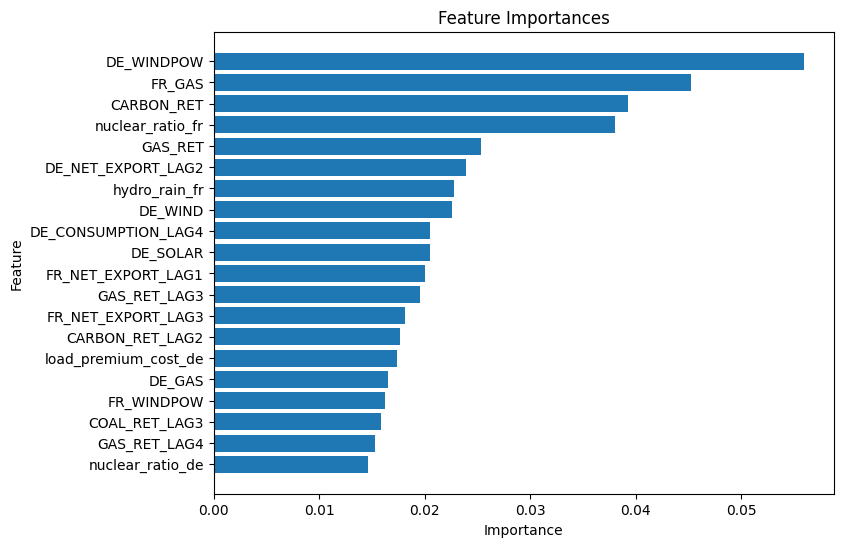

In [52]:
# Top 20 features
top_num_features = 20

# Extract feature importances using sklearn and create a DataFrame
feature_importances_node_impurity = pd.DataFrame(
    data=model.feature_importances_,
    index=model.feature_names_in_,
    columns=['Importances']    
).sort_values(by='Importances',ascending=True).tail(top_num_features)

# Plot the importances
importances = feature_importances_node_impurity['Importances']
plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_importances_node_impurity.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()